In [1]:
import pandas as pd
import statsmodels.api as sm
pd.options.display.max_rows = 20

# Data

## Load cleaned data from last lecture

In [2]:
# Load cleaned Compustat data from last lecture
comp_cgs = pd.read_pickle('../data/comp_cgs.zip')
comp_cgs.head(2)

,permno,year,dtdate,AG,L2AG,at,Leverage,ROA
2,10001,1987,1987-06-30,-0.038474,NaN,11.771,0.255432,0.026506
3,10001,1988,1988-06-30,-0.003058,-0.038474,11.735,0.244669,0.046187


In [3]:
# Load cleaned CRSP data (for table 1) from last lecture
crsp_table1 = pd.read_pickle('../data/crsp_cgs_table1.zip')
crsp_table1.head(2)

,permno,mdate,MV,BHRET6,BHRET36,FBHRET12
0,10000,1986-02,11.96,NaN,NaN,-0.875000
1,10000,1986-03,16.33,NaN,NaN,-0.943662


## Merge Compustat data from year t, with CRSP data from June, year t+1

In [4]:
# Keep only the CRSP data in Junes
crsp_table1 = crsp_table1.loc[crsp_table1['mdate'].dt.month==6,:].copy()
crsp_table1.head()

,permno,mdate,MV,BHRET6,BHRET36,FBHRET12
4,10000,1986-06,11.734594,NaN,NaN,NaN
20,10001,1986-06,6.033125,NaN,NaN,0.023884
32,10001,1987-06,5.822125,-0.131644,NaN,0.140535
44,10001,1988-06,6.200000,0.101995,NaN,0.199810
56,10001,1989-06,7.007000,0.136718,0.401108,0.468434


In [5]:
# Create year variable in CRSP data
crsp_table1['crsp_year'] = crsp_table1['mdate'].dt.year
crsp_table1.head()

,permno,mdate,MV,BHRET6,BHRET36,FBHRET12,crsp_year
4,10000,1986-06,11.734594,NaN,NaN,NaN,1986
20,10001,1986-06,6.033125,NaN,NaN,0.023884,1986
32,10001,1987-06,5.822125,-0.131644,NaN,0.140535,1987
44,10001,1988-06,6.200000,0.101995,NaN,0.199810,1988
56,10001,1989-06,7.007000,0.136718,0.401108,0.468434,1989


In [6]:
# Add 1 to the year in Compustat, so that accounting data in year t gets merged with returns from year t+1
comp_cgs['next_year'] = comp_cgs['year'] + 1

In [7]:
# Merge Compustat data from year t, with CRSP data from June, year t+1
andata = comp_cgs.merge(crsp_table1, how = 'inner',
                        left_on = ['permno','next_year'], right_on = ['permno','crsp_year'])
andata.head()

,permno,year,dtdate,AG,L2AG,at,Leverage,ROA,next_year,mdate,MV,BHRET6,BHRET36,FBHRET12,crsp_year
0,10001,1987,1987-06-30,-0.038474,NaN,11.771,0.255432,0.026506,1988,1988-06,6.20000,0.101995,NaN,0.199810,1988
1,10001,1988,1988-06-30,-0.003058,-0.038474,11.735,0.244669,0.046187,1989,1989-06,7.00700,0.136718,0.401108,0.468434,1989
2,10001,1989,1989-06-30,0.582020,-0.003058,18.565,0.643801,0.065069,1990,1990-06,10.05225,-0.011095,1.009441,0.140009,1990
3,10001,1990,1990-06-30,0.017021,0.582020,18.881,0.396984,0.059901,1991,1991-06,11.26650,0.137278,1.008516,0.175542,1991
4,10001,1991,1991-06-30,0.038028,0.017021,19.599,0.380012,0.054748,1992,1992-06,12.63125,-0.168310,0.967890,0.466211,1992


In [8]:
andata.shape

(138746, 15)

# Figure 1

In [9]:
# Figure 1 from the paper
stats = andata.groupby('year')['AG'].agg(['mean','median','std'])
stats.head()

,mean,median,std
year,,,
1981,0.199782,0.103294,0.475629
1982,0.120727,0.054256,0.500300
1983,0.206967,0.075210,1.162631
1984,0.183264,0.092669,0.523415
1985,0.177480,0.070489,0.910923


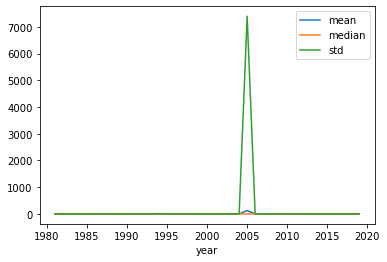

In [10]:
stats.plot();

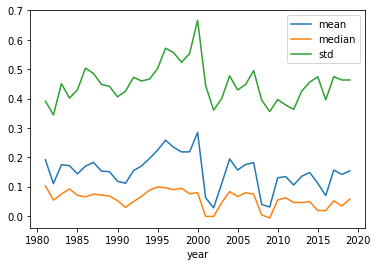

In [11]:
# Winsorize AG and try Figure 1 again
andata['AG_wins'] = andata['AG'].clip(lower=andata['AG'].quantile(0.01), 
                                      upper=andata['AG'].quantile(0.99))
# Figure 1
andata.groupby('year')['AG_wins'].agg(['mean','median','std']).plot();

# Create asset-growth (AG) deciles

In [12]:
# Create AG deciles (every year)
andata['AG_decile'] = andata.groupby('year')['AG']\
                            .transform(lambda x: 
                                       pd.qcut(x, q=10, labels=range(1,11))
                                      )

In [13]:
# Check how many observations in each AG decile
andata['AG_decile'].value_counts(sort=False)

1     13890
2     13874
3     13871
4     13870
5     13876
6     13867
7     13867
8     13874
9     13871
10    13886
Name: AG_decile, dtype: int64

In [14]:
# Save for later use
andata[['permno','mdate','AG_decile']].copy().to_pickle('../data/cgs_AG_deciles.zip')

# Summary statistics (Table 1)

In [15]:
# Restrict the sample period to the one in the paper
andata = andata.loc[andata['year'].between(1968,2002),:].copy()
andata['year'].describe()

count    88567.000000
mean      1992.010275
std          6.216007
min       1981.000000
25%       1987.000000
50%       1992.000000
75%       1997.000000
max       2002.000000
Name: year, dtype: float64

In [16]:
# Create list with variable names we want to summarize
sumthese = ['AG','L2AG','at','MV','Leverage','ROA','BHRET6','BHRET36']

In [17]:
# Calculate median values within each AG decile, every year
medians = andata.groupby(['AG_decile','year'])[sumthese].median()
medians

AG      L2AG        at          MV  Leverage       ROA  \
AG_decile year                                                                 
1         1981 -0.156534       NaN   21.1345    7.203563  0.229742 -0.015460   
          1982 -0.238448  0.027319    9.2700   12.730500  0.183496 -0.139899   
          1983 -0.229104 -0.039075   14.6480    8.373375  0.201748 -0.142807   
          1984 -0.234161 -0.022007   12.7145    8.697719  0.190783 -0.196343   
          1985 -0.313274 -0.010333   10.1480    9.214063  0.180496 -0.300224   
...                  ...       ...       ...         ...       ...       ...   
10        1998  1.229145  0.248939  167.6615  169.757875  0.785783  0.021279   
          1999  1.357963  0.212174  209.6170  311.982062  0.493111  0.011233   
          2000  1.922917  0.187752  229.2415  344.086705  0.107849 -0.058293   
          2001  0.765903  0.211994  234.1040  280.906659  0.271175  0.020858   
          2002  0.571702  0.124097  249.1590  375.585791  0.275448  0.038501   

                  BHRET6   BHRET36  
AG_decile year                      
1         1981 -0.074537       NaN  
          1982  0.544236  0.095549  
          1983 -0.151481 -0.583333  
          1984  0.055556 -0.407168  
          1985  0.073529 -0.722479  
...                  ...       ...  
10        1998 -0.029114  0.116597  
          1999 -0.109476  0.591549  
          2000 -0.130450  0.488128  
          2001 -0.251107  0.222919  
          2002  0.190315  0.366243  

[220 rows x 8 columns]

In [18]:
# Calculate averages of the annual medians, for each AG portfolio separately  (Table 1)
Table1 = medians.groupby('AG_decile')[sumthese].mean()
Table1

,AG,L2AG,at,MV,Leverage,ROA,BHRET6,BHRET36
AG_decile,,,,,,,,
1,-0.292132,-0.027666,19.849545,20.086016,0.128903,-0.307385,0.080930,-0.512516
2,-0.113047,0.002830,47.862864,31.512131,0.198275,-0.057847,0.094522,-0.265142
3,-0.038602,0.022827,101.886864,61.553354,0.234033,0.008679,0.096292,-0.031078
4,0.008625,0.040892,155.610909,106.641705,0.241524,0.030996,0.089255,0.159314
5,0.047712,0.060157,186.173614,136.166537,0.248173,0.041317,0.088291,0.279760
6,0.089594,0.083457,171.516727,140.993278,0.234498,0.050478,0.080265,0.341050
7,0.142033,0.110151,155.325705,153.609485,0.224782,0.055813,0.079332,0.378675
8,0.222567,0.146551,127.493750,148.647825,0.241273,0.058865,0.066603,0.462167
9,0.385785,0.184534,100.010364,140.504525,0.298602,0.054623,0.047157,0.546036


## Differences between high- and low-AG firms (Spreads)

In [19]:
# Calculate spreads (diffences) in meadians between AG deciles 1 and 10
d1 = medians.loc[1,:]
d1 

,AG,L2AG,at,MV,Leverage,ROA,BHRET6,BHRET36
year,,,,,,,,
1981,-0.156534,NaN,21.1345,7.203563,0.229742,-0.015460,-7.453705e-02,NaN
1982,-0.238448,0.027319,9.2700,12.730500,0.183496,-0.139899,5.442360e-01,0.095549
1983,-0.229104,-0.039075,14.6480,8.373375,0.201748,-0.142807,-1.514806e-01,-0.583333
1984,-0.234161,-0.022007,12.7145,8.697719,0.190783,-0.196343,5.555555e-02,-0.407168
1985,-0.313274,-0.010333,10.1480,9.214063,0.180496,-0.300224,7.352940e-02,-0.722479
...,...,...,...,...,...,...,...,...
1998,-0.318542,-0.022003,22.4040,41.305687,0.061048,-0.422993,8.552632e-02,-0.562500
1999,-0.292172,-0.033717,25.9085,46.752984,0.073241,-0.329393,-6.060653e-09,-0.400000
2000,-0.299783,-0.010038,45.3865,28.847051,0.059689,-0.364766,2.000000e-01,-0.694769


In [20]:
d10 = medians.loc[10,:]
d10

,AG,L2AG,at,MV,Leverage,ROA,BHRET6,BHRET36
year,,,,,,,,
1981,0.851511,NaN,27.2525,27.287156,0.519440,0.055673,-0.234994,NaN
1982,0.587385,0.313213,34.2610,58.212000,0.531385,0.044799,0.406984,1.948354
1983,0.960828,0.167609,30.0000,38.586000,0.369032,0.049919,-0.201324,0.445114
1984,0.815741,0.204685,29.5945,32.943000,0.527136,0.043982,0.083349,0.823529
1985,0.786492,0.221875,41.1470,63.686250,0.604671,0.041829,0.131579,0.243881
...,...,...,...,...,...,...,...,...
1998,1.229145,0.248939,167.6615,169.757875,0.785783,0.021279,-0.029114,0.116597
1999,1.357963,0.212174,209.6170,311.982062,0.493111,0.011233,-0.109476,0.591549
2000,1.922917,0.187752,229.2415,344.086705,0.107849,-0.058293,-0.130450,0.488128


In [21]:
d_spread = d10 - d1 
d_spread

,AG,L2AG,at,MV,Leverage,ROA,BHRET6,BHRET36
year,,,,,,,,
1981,1.008045,NaN,6.1180,20.083594,0.289698,0.071133,-0.160457,NaN
1982,0.825834,0.285894,24.9910,45.481500,0.347889,0.184698,-0.137252,1.852805
1983,1.189933,0.206684,15.3520,30.212625,0.167284,0.192726,-0.049843,1.028447
1984,1.049902,0.226692,16.8800,24.245281,0.336353,0.240325,0.027793,1.230697
1985,1.099766,0.232208,30.9990,54.472188,0.424175,0.342053,0.058050,0.966360
...,...,...,...,...,...,...,...,...
1998,1.547688,0.270942,145.2575,128.452188,0.724735,0.444273,-0.114640,0.679097
1999,1.650134,0.245891,183.7085,265.229078,0.419870,0.340626,-0.109476,0.991549
2000,2.222700,0.197790,183.8550,315.239654,0.048161,0.306473,-0.330450,1.182897


In [22]:
# Calculate means for the spreads
Spread = d_spread.mean()
Spread

AG            1.292361
L2AG          0.224090
at           70.501523
MV          105.858883
Leverage      0.347954
ROA           0.334991
BHRET6       -0.074527
BHRET36       1.111352
dtype: float64

In [23]:
# Convert spreads to a dataframe
Spread_df = pd.DataFrame(Spread, columns = ['Spread'], index = Table1.columns).transpose()
Spread_df

,AG,L2AG,at,MV,Leverage,ROA,BHRET6,BHRET36
Spread,1.292361,0.22409,70.501523,105.858883,0.347954,0.334991,-0.074527,1.111352


In [24]:
# Calculate tstatistics for the spreads
tstat = sm.stats.ttest_ind(d10.dropna(), d1.dropna())[0]
tstat

array([18.24803015, 14.81442456,  4.29417608,  4.53683213,  8.52451531,
        9.47088405, -1.23559743, 10.80911867])

In [25]:
# Convert it to a dataframe
tstat_df = pd.DataFrame(tstat, columns = ['tstat'], index = Table1.columns).transpose()
tstat_df

,AG,L2AG,at,MV,Leverage,ROA,BHRET6,BHRET36
tstat,18.24803,14.814425,4.294176,4.536832,8.524515,9.470884,-1.235597,10.809119


In [26]:
# Append spreads and tstats to the table
Table1_full = pd.concat([Table1, Spread_df, tstat_df], axis = 0)
Table1_full

,AG,L2AG,at,MV,Leverage,ROA,BHRET6,BHRET36
1,-0.292132,-0.027666,19.849545,20.086016,0.128903,-0.307385,0.080930,-0.512516
2,-0.113047,0.002830,47.862864,31.512131,0.198275,-0.057847,0.094522,-0.265142
3,-0.038602,0.022827,101.886864,61.553354,0.234033,0.008679,0.096292,-0.031078
4,0.008625,0.040892,155.610909,106.641705,0.241524,0.030996,0.089255,0.159314
5,0.047712,0.060157,186.173614,136.166537,0.248173,0.041317,0.088291,0.279760
6,0.089594,0.083457,171.516727,140.993278,0.234498,0.050478,0.080265,0.341050
7,0.142033,0.110151,155.325705,153.609485,0.224782,0.055813,0.079332,0.378675
8,0.222567,0.146551,127.493750,148.647825,0.241273,0.058865,0.066603,0.462167
9,0.385785,0.184534,100.010364,140.504525,0.298602,0.054623,0.047157,0.546036
10,1.000230,0.196424,90.351068,125.944899,0.476857,0.027607,0.006403,0.598836
